# ISA for different $\alpha$ and $N=20 000$

Ok, we would like to see the impact of different $\alpha$ (reminder $\mathcal{L}_{tot} = \mathcal{L}_{BCE} + \alpha \cdot \mathcal{L}_{MSE}$ ) on the network. That's why we have trained networks with

$\alpha$ = 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 7, 10

Let's load these networks, evaluate them and see if we see some connection!

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import InvariantSlotAttention

# Set numpy seed for test set sampling 
np.random.seed(24082023)

from matplotlib.patches import Circle
import json

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [3]:
cID_all = ['isa-alpha0.5', 'isa-alpha1', 'isa-alpha1.5', 'isa-alpha2', 'isa-alpha2.5', 'isa-alpha3', 'isa-alpha3.5', 'isa-alpha4', 'isa-alpha4.5', 'isa-alpha5', 'isa-alpha7', 'isa-alpha10']

cID_prev = cID_all[0]
# only alpha differs for the networks so load everything else:
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [4]:
torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

**First check at which epoch to load the model!**

In [5]:
load_model_at = []
for cID_prev in cID_all:
    f = open(f'./../../code/models/{cID_prev}/loss.json')
    # returns JSON object as a dictionary
    losses = json.load(f)
    epoch_loss_min = np.argmin(losses["tot"])
    epoch_loss_min = round(epoch_loss_min, -3) # round to 1000 a model gets saved every 1000 epoch!
    load_model_at.append(epoch_loss_min)

In [6]:
print("Models will be loaded at epoch", load_model_at)

Models will be loaded at epoch [3000, 8000, 12000, 15000, 11000, 11000, 19000, 7000, 10000, 11000, 15000, 7000]


**Load new trained models too!**
To see how large the fluctuation of the models are depending on the initialization, I've trained the some of the models agian and will load these too! 

In [7]:
cID_all_new = ['isa-alpha1-check-fluc', 'isa-alpha1.5-check-fluc', 'isa-alpha2-check-fluc', 'isa-alpha2.5-check-fluc', 'isa-alpha3-check-fluc', 'isa-alpha3.5-check-fluc']

In [8]:
load_model_at_new = []
for cID_prev in cID_all_new:
    f = open(f'./../../code/models/{cID_prev}/loss.json')
    # returns JSON object as a dictionary
    losses = json.load(f)
    epoch_loss_min = np.argmin(losses["tot"])
    epoch_loss_min = round(epoch_loss_min, -3) # round to 1000 a model gets saved every 1000 epoch!
    load_model_at_new.append(epoch_loss_min)

In [16]:
print("Models will be loaded at epoch", load_model_at_new)

Models will be loaded at epoch [16000, 6000, 15000, 3000, 16000, 9000]


# Load models and evaluate!

Save performance while evaluating!

In [9]:
plt.style.use('standard_style.mlpstyle')

In [10]:
from train import hungarian_matching
import torch.nn.functional as F
import evaluation as ev

In [11]:
k_slots=3
max_n_rings=2
resolution=(32,32)

Starting from an earlier training 3000


/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/Invariant-Slot-Attention (ISA) methods/./../../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


KL-divergence:  0.017840369


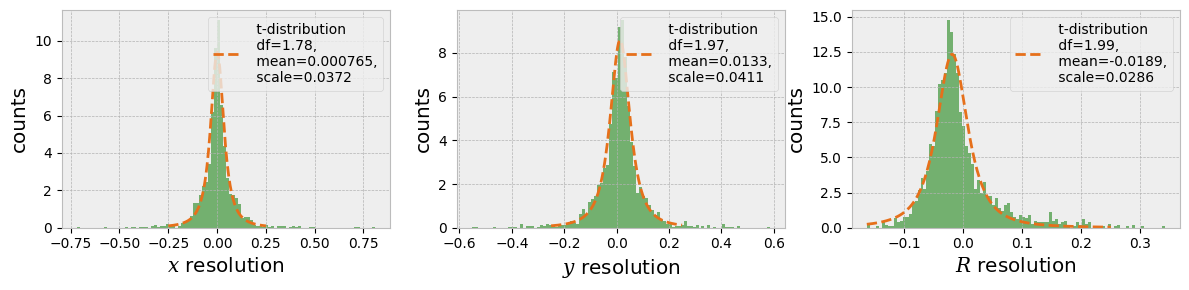

Starting from an earlier training 8000
KL-divergence:  0.014160966


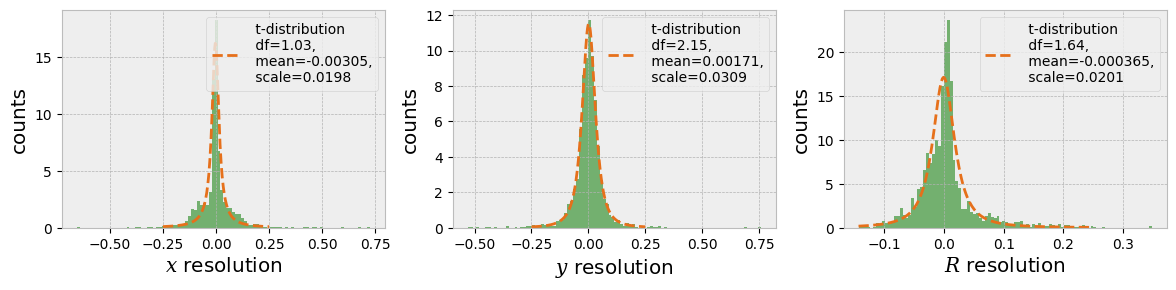

Starting from an earlier training 12000
KL-divergence:  0.006524497


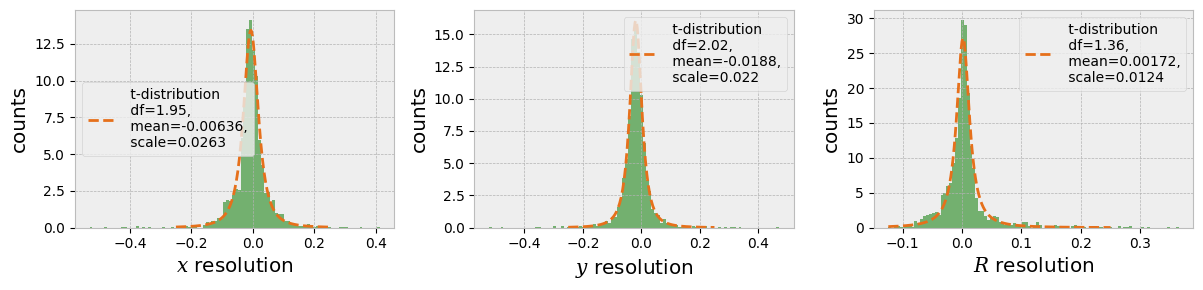

Starting from an earlier training 15000
KL-divergence:  0.014324522


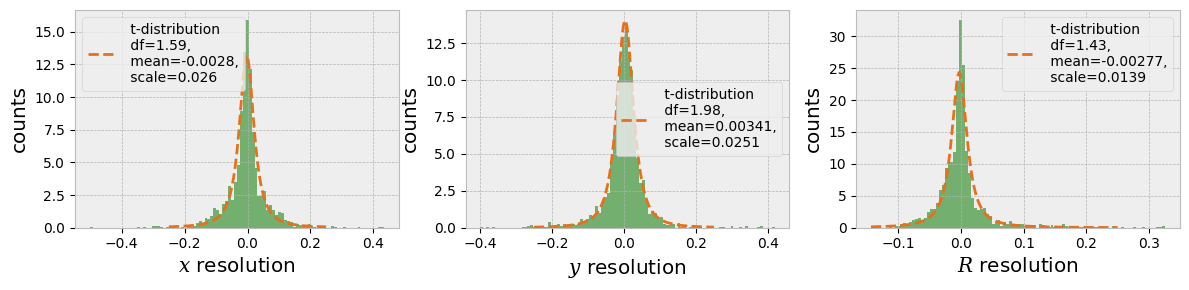

Starting from an earlier training 11000
KL-divergence:  0.007975584


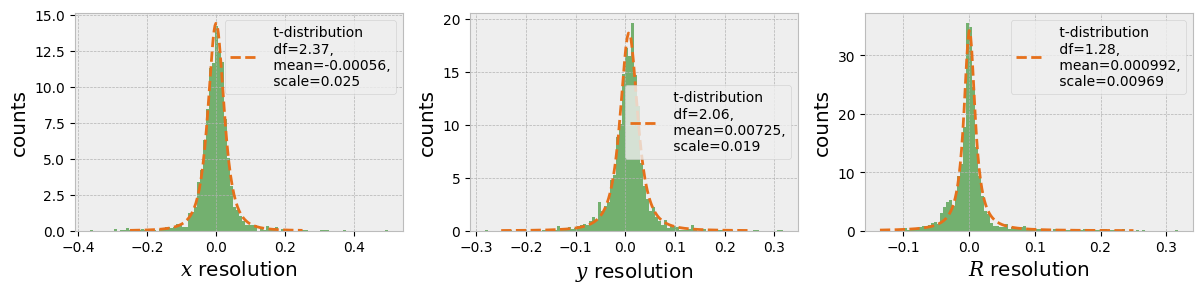

Starting from an earlier training 11000
KL-divergence:  0.008161953


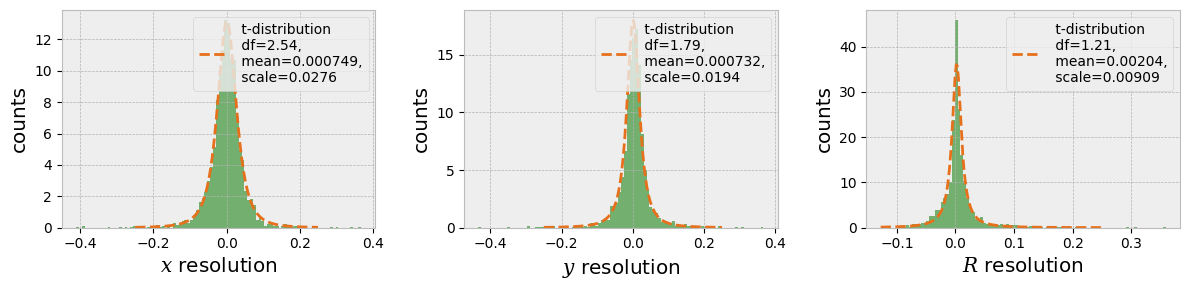

Starting from an earlier training 19000
KL-divergence:  0.0085008945


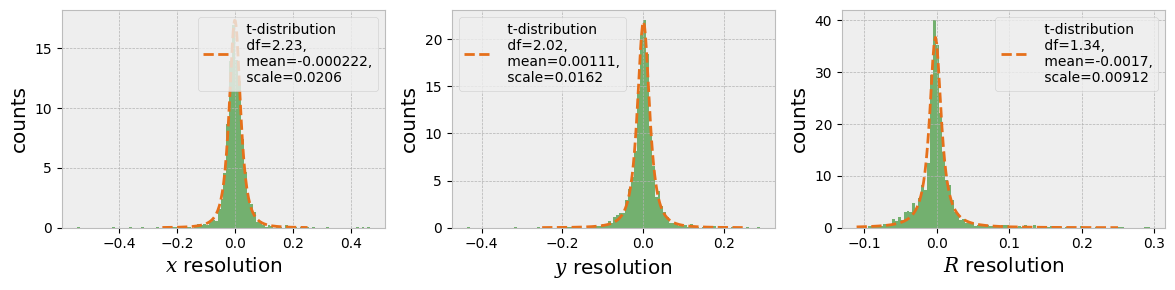

Starting from an earlier training 7000
KL-divergence:  0.011701653


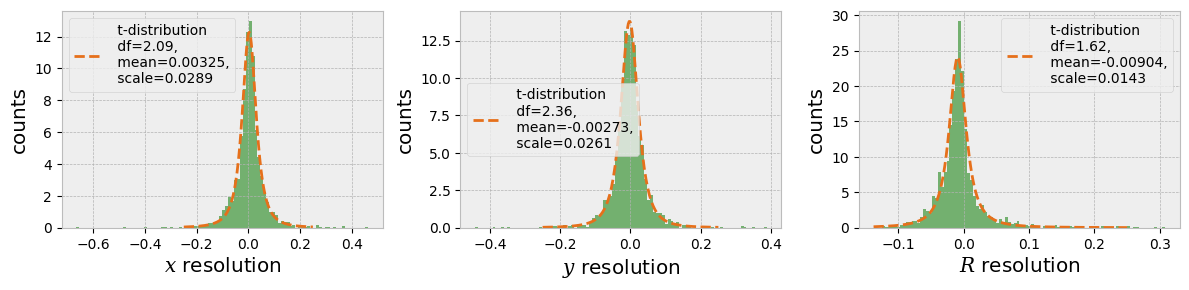

Starting from an earlier training 10000
KL-divergence:  0.012688914


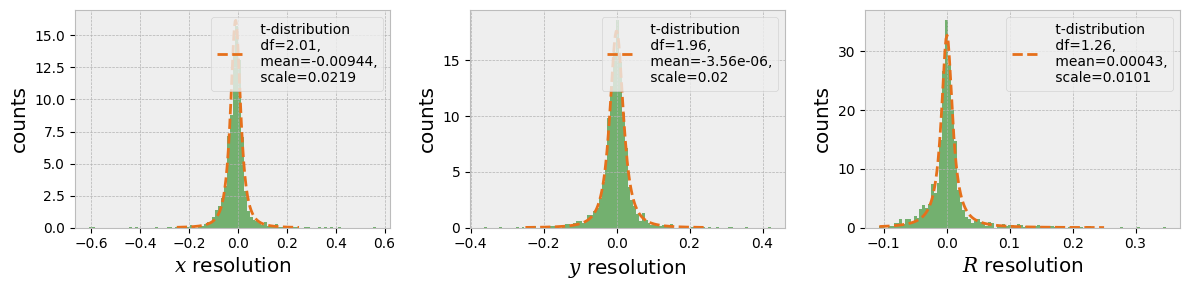

Starting from an earlier training 11000
KL-divergence:  0.01323954


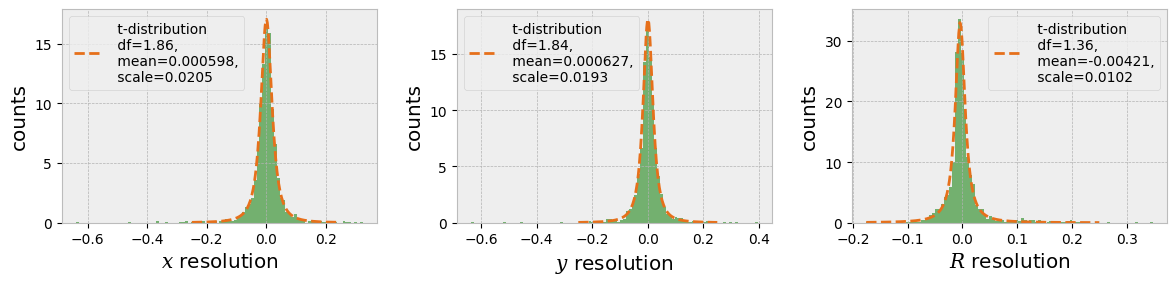

Starting from an earlier training 15000
KL-divergence:  0.013618856


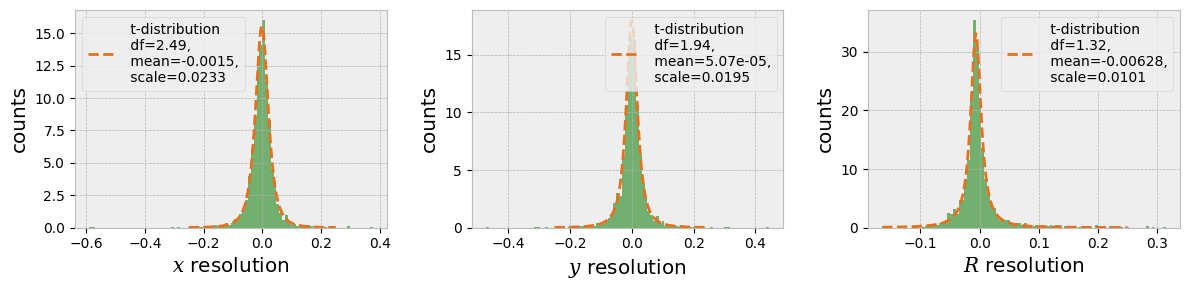

Starting from an earlier training 7000
KL-divergence:  0.012040482


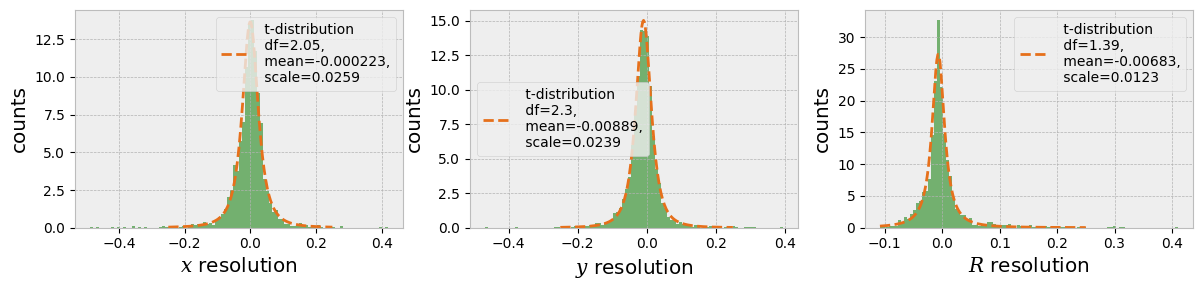

In [12]:
result = {}
for i, cID_prev in enumerate(cID_all):
    with open(f'./../../code/configs/{cID_prev}.yaml') as f:
        cd = yaml.safe_load(f)
    alpha = cd['opt']['alpha']
    
    m = InvariantSlotAttention(**hps)
    
    # load model
    lastIter = load_model_at[i]
    weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
    print(f'Starting from an earlier training',lastIter)

    m.load_state_dict(torch.load(weightPath,map_location=device))
    
    # make data
    bs = 1000
    kwargs = cd['data']
    X, Y, mask = make_batch(N_events=bs, **kwargs)
    
    # check network 
    with torch.no_grad():

        torch.manual_seed(torch_seed)
        queries, att, Y_pred = m(X)

        # Reshape the target mask to be flat in the pixels (same shape as att)
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      

        att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
        mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

        pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

        # pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
        indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        # Loss calc
        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

        Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean(axis=-1)

        # Calculate the loss
        #print(l_bce.shape)
        #print(l_mse.shape)
        li = l_bce + alpha*l_mse
        
        
        
        ### performance of network!
        kl_div = ev.KL_divergence(slots_sorted, rings_sorted)
        print("KL-divergence: ", kl_div)
        fit_params = ev.student_t(Y_pred_sorted, Y_true_sorted)
        # save results 
        result[cID_prev] = {"kl-div": kl_div, "t-fit": fit_params}
    

Ok same for new trained models!

Starting from an earlier training 16000
KL-divergence:  0.005069285


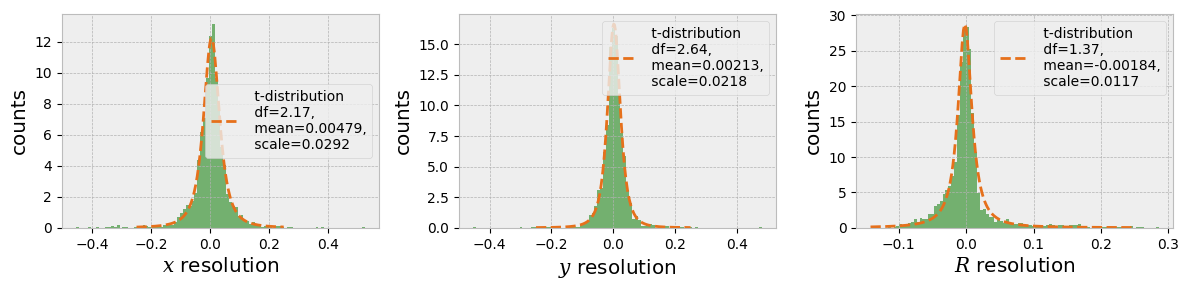

Starting from an earlier training 6000
KL-divergence:  0.014514317


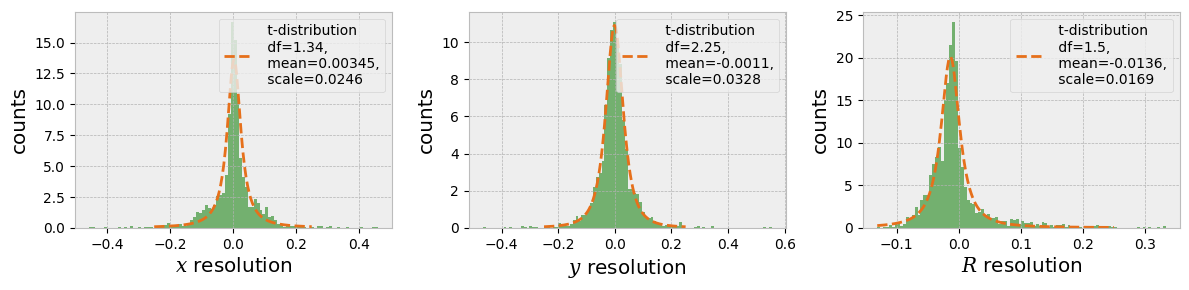

Starting from an earlier training 15000
KL-divergence:  0.004760746


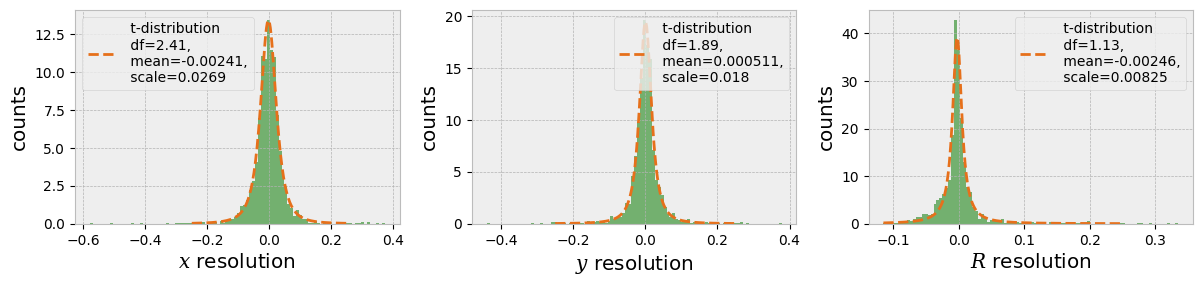

Starting from an earlier training 3000
KL-divergence:  0.015677387


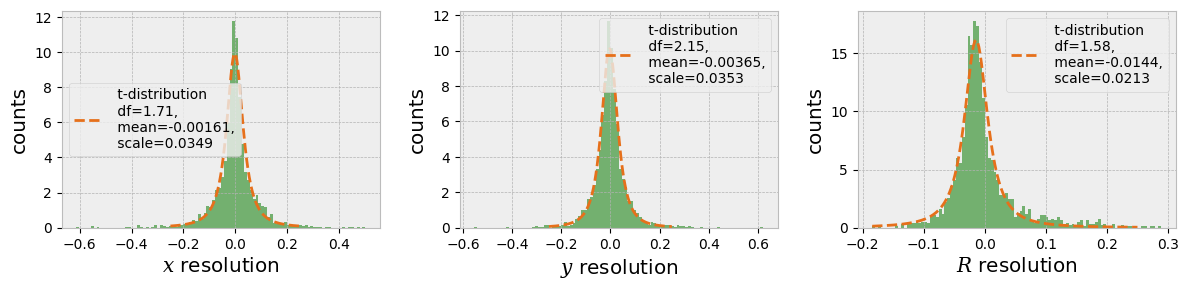

Starting from an earlier training 16000
KL-divergence:  0.010883791


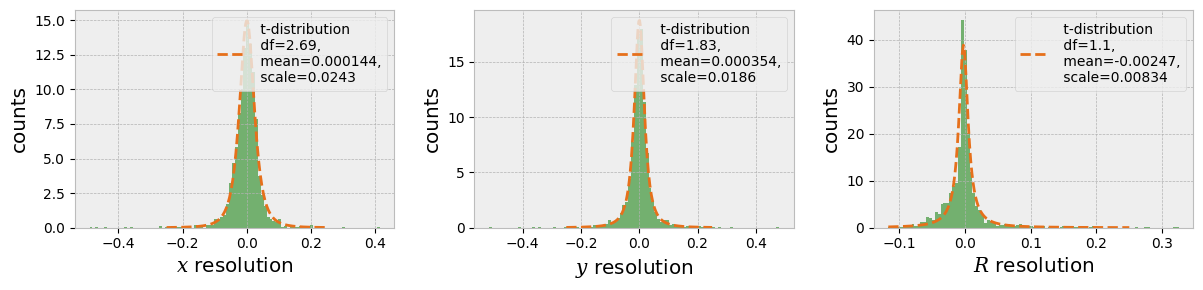

Starting from an earlier training 9000
KL-divergence:  0.012552643


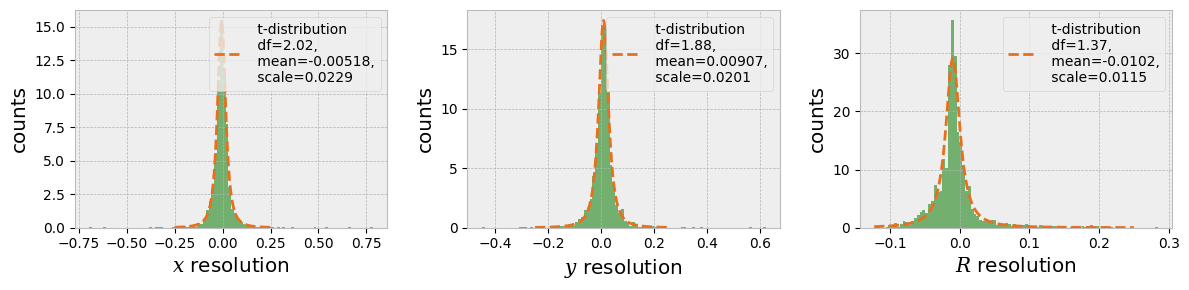

In [17]:
result_new = {}
for i, cID_prev in enumerate(cID_all_new):
    with open(f'./../../code/configs/{cID_prev}.yaml') as f:
        cd = yaml.safe_load(f)
    alpha = cd['opt']['alpha']
    
    m = InvariantSlotAttention(**hps)
    
    # load model
    lastIter = load_model_at_new[i]
    weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
    print(f'Starting from an earlier training',lastIter)

    m.load_state_dict(torch.load(weightPath,map_location=device))
    
    # make data
    bs = 1000
    kwargs = cd['data']
    X, Y, mask = make_batch(N_events=bs, **kwargs)
    
    # check network 
    with torch.no_grad():

        torch.manual_seed(torch_seed)
        queries, att, Y_pred = m(X)

        # Reshape the target mask to be flat in the pixels (same shape as att)
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      

        att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
        mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

        pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

        # pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
        indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        # Loss calc
        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

        Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean(axis=-1)

        # Calculate the loss
        #print(l_bce.shape)
        #print(l_mse.shape)
        li = l_bce + alpha*l_mse
        
        
        
        ### performance of network!
        kl_div = ev.KL_divergence(slots_sorted, rings_sorted)
        print("KL-divergence: ", kl_div)
        fit_params = ev.student_t(Y_pred_sorted, Y_true_sorted)
        # save results 
        result_new[cID_prev] = {"kl-div": kl_div, "t-fit": fit_params}
    

# Show results!

Let's make some nice plots to see which network performed best! 

In [18]:
alpha = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 7, 10])
kl_div_res = [a["kl-div"] for a in result.values()]

In [19]:
alpha_new = np.array([1, 1.5, 2, 2.5, 3, 3.5])
kl_div_res_new = [a["kl-div"] for a in result_new.values()]

In [20]:
print(kl_div_res)

[0.017840369, 0.014160966, 0.006524497, 0.014324522, 0.007975584, 0.008161953, 0.0085008945, 0.011701653, 0.012688914, 0.01323954, 0.013618856, 0.012040482]


KL-divergence:

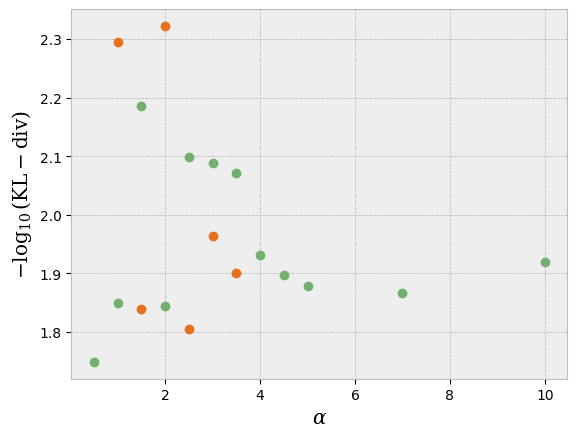

In [37]:
plt.plot(alpha, -np.log10(kl_div_res),"o")
plt.plot(alpha_new, -np.log10(kl_div_res_new),"o")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$- \log_{10} \mathrm{(KL-div)}$")
#plt.legend()

plt.show()

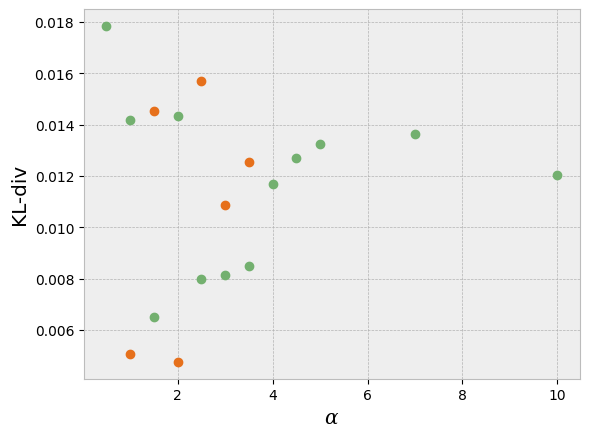

In [36]:
plt.plot(alpha, kl_div_res,"o")
plt.plot(alpha_new, kl_div_res_new,"o")
plt.xlabel(r"$\alpha$")
plt.ylabel("KL-div")
#plt.legend()

plt.show()

student-t fit: 

In [22]:
t_fit = np.zeros((len(alpha), 3, 3))
print(t_fit.shape)
for i, cID in enumerate(cID_all):
    t_fit[i] = result[cID]["t-fit"]

(12, 3, 3)


In [23]:
from matplotlib.pyplot import cycler

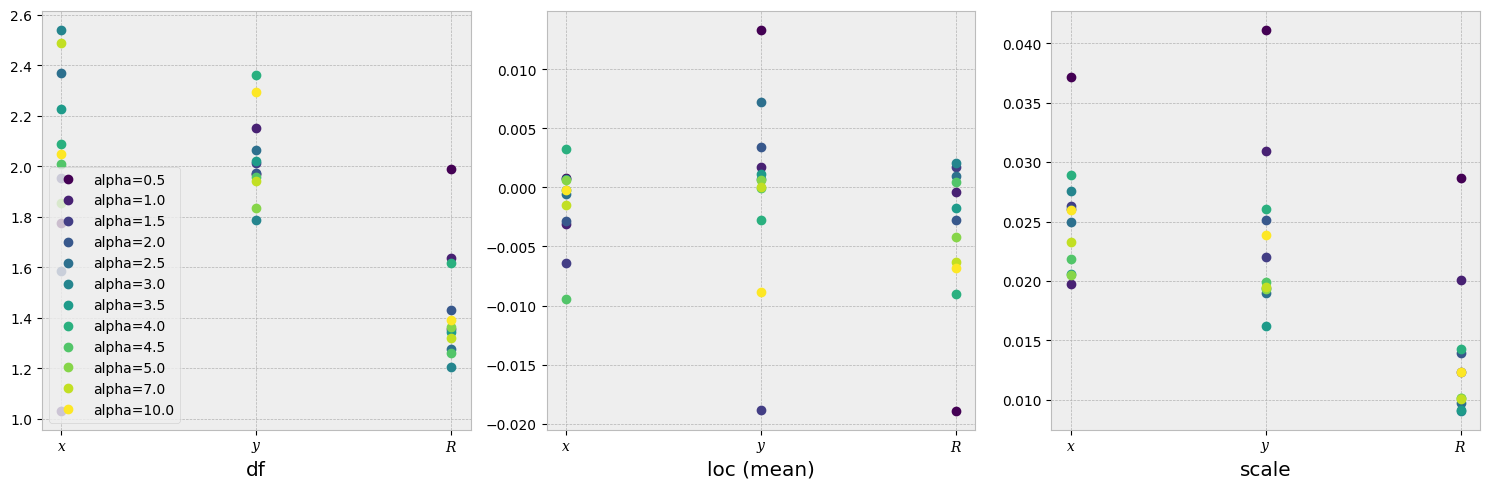

In [24]:
N = len(alpha)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))


fig = plt.figure(figsize=(15, 5))
xticks = ["$x$", "$y$", "$R$"]

fig.add_subplot(1,3, 1)
for i in range(len(alpha)):
    plt.plot(t_fit[i, :,0], "o", label=f"alpha={alpha[i]}")
plt.xticks(ticks=np.arange(3), labels=xticks)
plt.xlabel("df")
plt.legend()

fig.add_subplot(1,3, 2)
for i in range(len(alpha)):
    plt.plot(t_fit[i, :,1], "o")
plt.xticks(ticks=np.arange(3), labels=xticks)
plt.xlabel("loc (mean)")

fig.add_subplot(1,3, 3)
for i in range(len(alpha)):
    plt.plot(t_fit[i, :,2], "o")
plt.xticks(ticks=np.arange(3), labels=xticks)
plt.xlabel("scale")

plt.tight_layout()
plt.show()

# Losses

I have the feeling that many networks are not completly trained as it fails after some reason after some epochs. Lets check that!

In [25]:
plt.style.use('standard_style.mlpstyle')

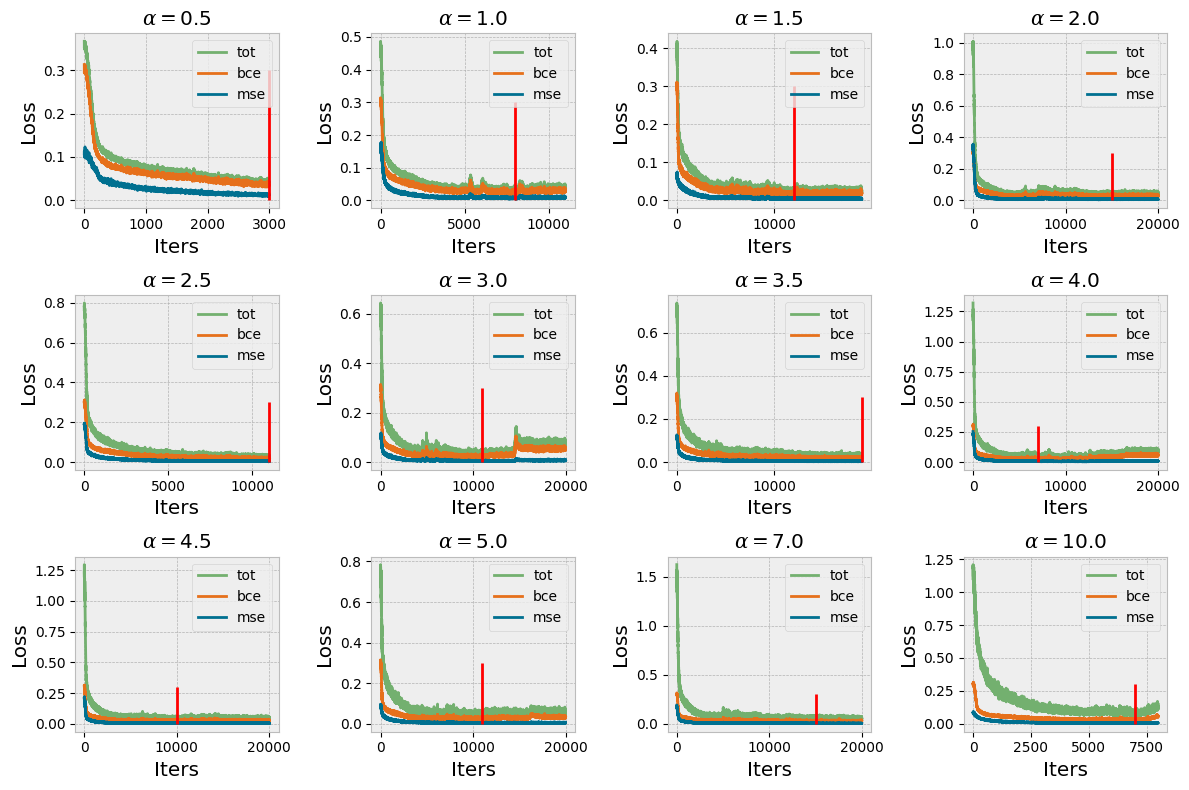

In [26]:
fig = plt.figure(figsize=(12, 8))

for i, cID_prev in enumerate(cID_all):
    f = open(f'./../../code/models/{cID_prev}/loss.json')
    # returns JSON object as a dictionary
    losses = json.load(f)
    fig.add_subplot(3,4, i+1)
    for k,v in losses.items():
        plt.title(r"$\alpha=$"+ str(alpha[i]))
        plt.plot(v,label=k)
        #print("loss ", k, " min: ", np.min(v), " at ", np.argmin(v))
    epoch_loss_min = np.argmin(losses["tot"])
    epoch_loss_min = round(epoch_loss_min, -3)
    plt.vlines([epoch_loss_min], 0, 0.3, colors="r")
    #print("load at epoch ", epoch_loss_min)
    plt.xlabel('Iters')
    plt.ylabel('Loss')
    plt.legend()
plt.tight_layout()
plt.show()

#  $\mathcal{L}_{tot} = \mathcal{L}_{BCE} + \alpha \cdot \mathcal{L}_{MSE}$

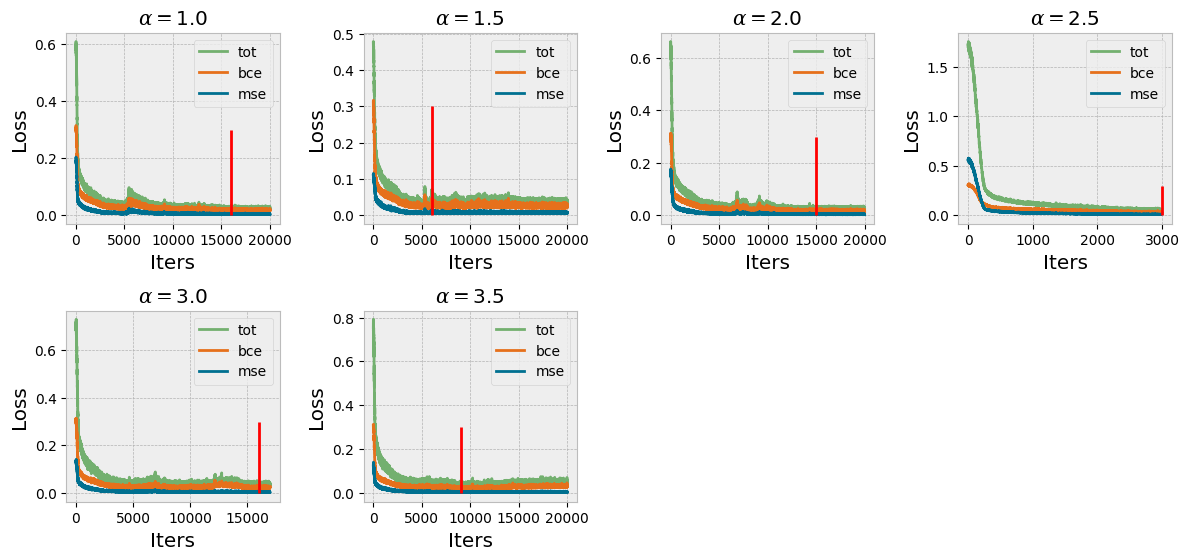

In [15]:
fig = plt.figure(figsize=(12, 8))

alpha_new = np.array([1, 1.5, 2, 2.5, 3, 3.5])
for i, cID_prev in enumerate(cID_all_new):
    f = open(f'./../../code/models/{cID_prev}/loss.json')
    # returns JSON object as a dictionary
    losses = json.load(f)
    fig.add_subplot(3,4, i+1)
    for k,v in losses.items():
        plt.title(r"$\alpha=$"+ str(alpha_new[i]))
        plt.plot(v,label=k)
        #print("loss ", k, " min: ", np.min(v), " at ", np.argmin(v))
    epoch_loss_min = np.argmin(losses["tot"])
    epoch_loss_min = round(epoch_loss_min, -3)
    plt.vlines([epoch_loss_min], 0, 0.3, colors="r")
    #print("load at epoch ", epoch_loss_min)
    plt.xlabel('Iters')
    plt.ylabel('Loss')
    plt.legend()
plt.tight_layout()
plt.show()